<a href="https://colab.research.google.com/github/muajnstu/Comparative-Analysis-of-KNN-Variants-for-Diabetes-Prediction-Using-Administrative-Health-data/blob/main/AUROC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


==== KNN ====
Accuracy      : 0.9877
Sensitivity   : 0.9877
Specificity   : 0.9995
G-Mean        : 0.9936
Type I Error  : 0.0005
Type II Error : 0.0123
F1 Score      : 0.9872
AUROC         : 0.9964

==== DistanceKNN ====
Accuracy      : 0.9892
Sensitivity   : 0.9892
Specificity   : 0.9996
G-Mean        : 0.9944
Type I Error  : 0.0004
Type II Error : 0.0108
F1 Score      : 0.9887
AUROC         : 0.9964

==== GeneralizedKNN ====
Accuracy      : 0.9883
Sensitivity   : 0.9883
Specificity   : 0.9996
G-Mean        : 0.9939
Type I Error  : 0.0004
Type II Error : 0.0117
F1 Score      : 0.9879
AUROC         : 0.9967

==== EuclideanKNN ====
Accuracy      : 0.9877
Sensitivity   : 0.9877
Specificity   : 0.9995
G-Mean        : 0.9936
Type I Error  : 0.0005
Type II Error : 0.0123
F1 Score      : 0.9872
AUROC         : 0.9964

==== ManhattanKNN ====
Accuracy      : 0.9836
Sensitivity   : 0.9836
Specificity   : 0.9994
G-Mean        : 0.9915
Type I Error  : 0.0006
Type II Error : 0.0164
F1 Score      

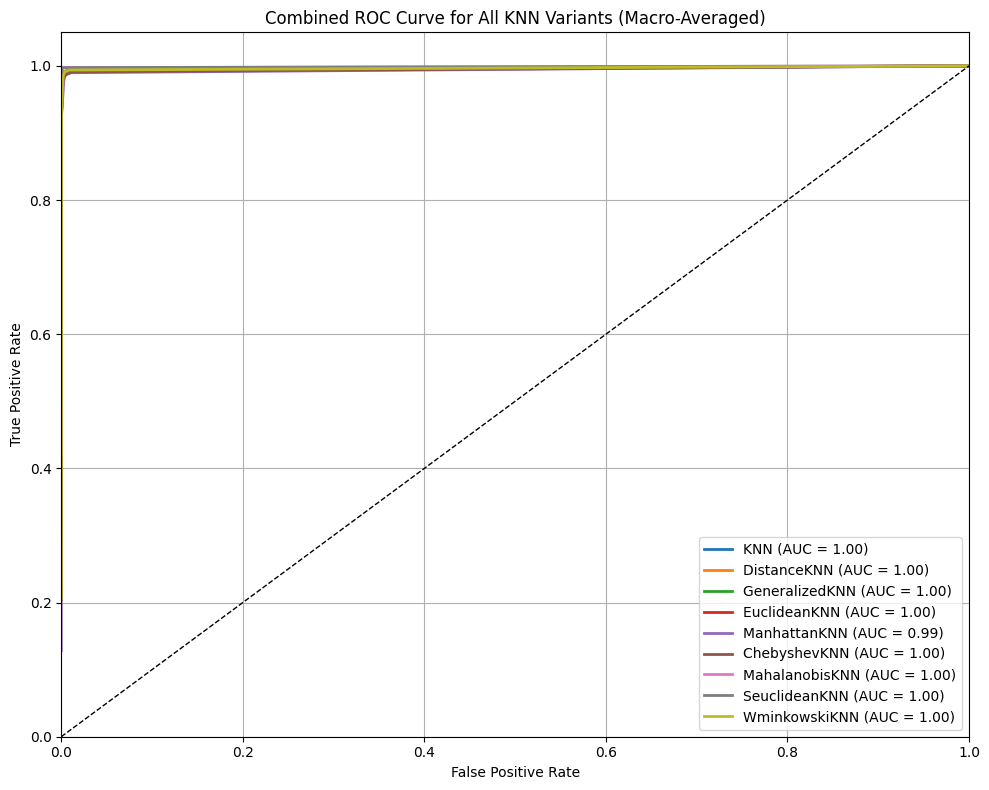


Project complete! All KNN variants evaluated and ROC curves plotted.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score,
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

# Load data
df = pd.read_csv('https://media.githubusercontent.com/media/shahriariit/opendataset/refs/heads/master/DBSCAN_DATA.csv')
X = df.drop(columns=['Cluster'])
y = df['Cluster']

# Handle imbalanced data with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=46,
    stratify=y_resampled
)

# Recalculate for Mahalanobis and seuclidean metrics
covariance_matrix = np.cov(X_train.T)
stabilized_covariance_matrix = covariance_matrix + np.eye(covariance_matrix.shape[0]) * 1e-6
inv_covariance_matrix = np.linalg.inv(stabilized_covariance_matrix)
variance_vector = np.var(X_train, axis=0)

# Define KNN Variants
knn_variants = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "DistanceKNN": KNeighborsClassifier(n_neighbors=3, weights='distance'),
    "GeneralizedKNN": KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=3),
    "EuclideanKNN": KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    "ManhattanKNN": KNeighborsClassifier(n_neighbors=3, metric='manhattan'),
    "ChebyshevKNN": KNeighborsClassifier(n_neighbors=3, metric='chebyshev'),
    "MahalanobisKNN": KNeighborsClassifier(n_neighbors=3, metric='mahalanobis', metric_params={'VI': inv_covariance_matrix}),
    "SeuclideanKNN": KNeighborsClassifier(n_neighbors=3, metric='seuclidean', metric_params={'V': variance_vector}),
    "WminkowskiKNN": KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=3, metric_params={'w': np.ones(X_train.shape[1])}),
}

# Metric Printer
def print_metrics(y_true, y_pred, y_prob=None):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    num_classes = cm.shape[0]

    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    specificity = np.mean([TN[i] / (TN[i] + FP[i]) if (TN[i] + FP[i]) > 0 else 0 for i in range(num_classes)])
    sensitivity = np.mean([TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0 for i in range(num_classes)])
    gmean = np.sqrt(specificity * sensitivity)
    type1 = np.mean([FP[i] / (FP[i] + TN[i]) if (FP[i] + TN[i]) > 0 else 0 for i in range(num_classes)])
    type2 = np.mean([FN[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0 for i in range(num_classes)])
    fmeasure = f1_score(y_true, y_pred, average='macro')

    auc_score = 0
    if y_prob is not None and y_prob.shape[1] > 1:
        try:
            auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
        except:
            auc_score = 0

    print(f"Accuracy      : {accuracy:.4f}")
    print(f"Sensitivity   : {sensitivity:.4f}")
    print(f"Specificity   : {specificity:.4f}")
    print(f"G-Mean        : {gmean:.4f}")
    print(f"Type I Error  : {type1:.4f}")
    print(f"Type II Error : {type2:.4f}")
    print(f"F1 Score      : {fmeasure:.4f}")
    print(f"AUROC         : {auc_score:.4f}")
    return auc_score

# Binarize labels for ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Storage for ROC plotting
model_auc_dict = {}
plt.figure(figsize=(10, 8))

for name, model in knn_variants.items():
    print(f"\n==== {name} ====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_prob = None
    if hasattr(model, "predict_proba"):
        try:
            y_prob = model.predict_proba(X_test)
        except:
            pass

    auc_score = print_metrics(y_test, y_pred, y_prob)

    # ROC for multiclass
    if y_prob is not None and y_prob.shape[1] > 1:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute macro-average ROC curve
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(classes)
        macro_auc = auc(all_fpr, mean_tpr)
        model_auc_dict[name] = macro_auc

        # Plot
        plt.plot(all_fpr, mean_tpr, lw=2, label=f"{name} (AUC = {macro_auc:.2f})")

# Finalize combined ROC plot
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curve for All KNN Variants (Macro-Averaged)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nProject complete! All KNN variants evaluated and ROC curves plotted.")


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score,
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

In [2]:
# Load data
df = pd.read_csv('https://media.githubusercontent.com/media/shahriariit/opendataset/refs/heads/master/DBSCAN_DATA.csv')
X = df.drop(columns=['Cluster'])
y = df['Cluster']

# Handle imbalanced data with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=46,
    stratify=y_resampled
)
# Recalculate for Mahalanobis and seuclidean metrics
covariance_matrix = np.cov(X_train.T)
stabilized_covariance_matrix = covariance_matrix + np.eye(covariance_matrix.shape[0]) * 1e-6
inv_covariance_matrix = np.linalg.inv(stabilized_covariance_matrix)
variance_vector = np.var(X_train, axis=0)
# Define KNN Variants
knn_variants = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "DistanceKNN": KNeighborsClassifier(n_neighbors=3, weights='distance'),
    "GeneralizedKNN": KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=3),
    "EuclideanKNN": KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    "ManhattanKNN": KNeighborsClassifier(n_neighbors=3, metric='manhattan'),
    "ChebyshevKNN": KNeighborsClassifier(n_neighbors=3, metric='chebyshev'),
    "MahalanobisKNN": KNeighborsClassifier(n_neighbors=3, metric='mahalanobis', metric_params={'VI': inv_covariance_matrix}),
    "SeuclideanKNN": KNeighborsClassifier(n_neighbors=3, metric='seuclidean', metric_params={'V': variance_vector}),
    "WminkowskiKNN": KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=3, metric_params={'w': np.ones(X_train.shape[1])}),
}

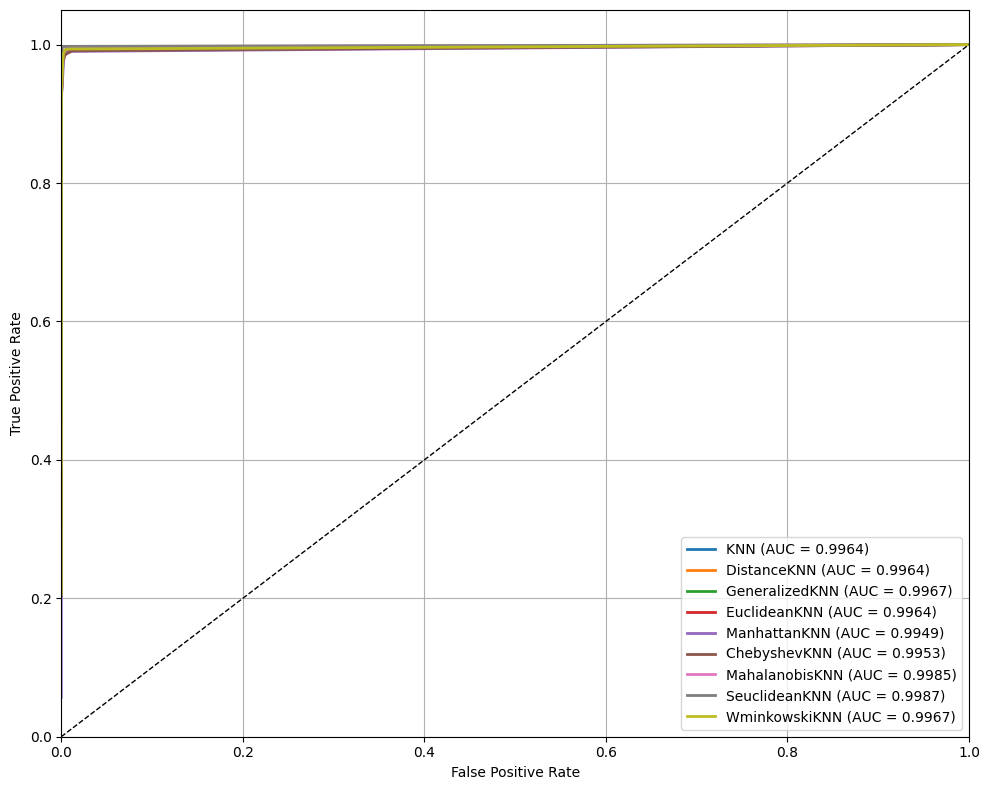

In [3]:
# Binarize labels for ROC
from sklearn.preprocessing import label_binarize
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

model_auc_dict = {}
plt.figure(figsize=(10, 8))

for name, model in knn_variants.items():
    model.fit(X_train, y_train)
    y_prob = None
    if hasattr(model, "predict_proba"):
        try:
            y_prob = model.predict_proba(X_test)
        except:
            continue
    if y_prob is not None and y_prob.shape[1] > 1:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(classes)
        macro_auc = auc(all_fpr, mean_tpr)
        model_auc_dict[name] = macro_auc
        plt.plot(all_fpr, mean_tpr, lw=2, label=f"{name} (AUC = {macro_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()